# Data Challenge : Prediction of stock market Volume
By <i>Fabrice ZAPFACK</i> & <i>Basile CALDERAN</i>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Reading the data
The data for this challenge were given as .csv. <br/>
We used pandas library in other to read them and store them in memory as dataframes

In [2]:
trainDF = pd.read_csv('data/training_input.csv')
testDF = pd.read_csv('data/testing_input.csv')
otherDF = pd.read_csv('data/challenge_output_data_training_file_prediction_of'
                      '_transaction_volumes_in_financial_markets.csv', sep=';')

# Data Cleaning
We first analysed the data given by computing some statistics on the data

In [89]:
# trainDF.describe()

In [90]:
# testDF.describe()

In [91]:
# otherDF.describe()

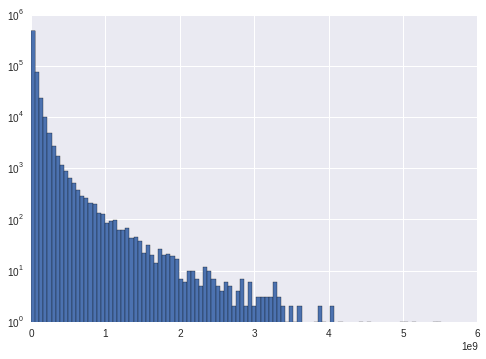

In [6]:
fig, ax = plt.subplots()
otherDF['TARGET'].hist(ax=ax, bins=100)
ax.set_yscale('log')

From that simple analysis, We were able to make some conclusions :
- We have something like an exponential decrease of the target variable (even in the log scale), so larger values don't appear a lot. <br />
    This will make the prediction task more difficult as our error will increase a lot as soon as we will do a very wrong prediction. => Can we normalize
    
- We also realize the presence of negative values. We decided to replaced them with NaN as it doesn't make sense to have negatives volumes

- We also realize that it will be very challenging to fing a good way to deal with missing values and interpolate the time series because we have a lot of missing values in both the training and the test datasets.

## Normalization
2 strategies have been tested but we didn't keep them because our final prediction model performed better without:

    - We thought it could help to center and/or normalize the time serie in each line but this made our prediction model less performant.
    - We thought to compute the logarithm of the volumes traded in order to rescale those quantities, but again, it made the model less performant

## Negative Values

In [7]:
trainDF[trainDF<0]=np.nan
testDF[testDF<0]=np.nan

## Missing values
In Order to impute the missing values, we evaluated 4 differents strategies :

    - A linear interpolation of order 1
    - Impute missing values with mean values per product
    - Impute missing values with mean values per date
    - Impute missing values with mean values in the training dataset
We compared those strategies by taking some observations with no missing values, replace a fraction of those values with NaNs and compute the error of the interpolation

In [92]:
import random
ratio_missing=trainDF.isnull().sum(axis=1).div(trainDF.shape[1])
trainDF2 = trainDF[ratio_missing==0]
k=20
idx = np.random.randint(0,trainDF2.shape[0],k)
ratio_missing = np.linspace(0,1,30)
score_product = np.zeros([k,ratio_missing.shape[0]])
score_date = np.zeros([k,ratio_missing.shape[0]])
score_lin_interp = np.zeros([k,ratio_missing.shape[0]])
score_mean_train = np.zeros([k,ratio_missing.shape[0]])
for ir in range(ratio_missing.shape[0]):
    r = ratio_missing[ir]
    for i in range(k):
        same_product = trainDF[trainDF.product_id==trainDF2.iloc[idx[i],:]['product_id']] 
        same_date = trainDF[trainDF.date==trainDF2.iloc[idx[i],:]['date']] 
        x_true = trainDF2.iloc[idx[i],3:]
        x_missing = x_true.copy()
        x_missing[random.sample(xrange(0,x_true.shape[0]), np.int(x_true.shape[0]*r))]=np.nan 
        x_interp = x_missing.interpolate(method='linear',limit_direction='both',limit=1000)
        score_lin_interp[i,ir] = np.abs(x_true.sum() - x_interp.sum())/x_true.sum()*100
        x_interp = x_missing.copy()
        x_interp = x_interp.fillna(same_product.ix[:,3:].mean())
        score_product[i,ir] = np.abs(x_true.sum() - x_interp.sum())/x_true.sum()*100
        x_interp = x_missing.copy()
        x_interp = x_interp.fillna(same_date.ix[:,3:].mean())
        score_date[i,ir] = np.abs(x_true.sum() - x_interp.sum())/x_true.sum()*100
        x_interp = x_missing.copy()
        x_interp = x_interp.fillna(trainDF.ix[:,3:].mean())
        score_mean_train[i,ir] = np.abs(x_true.sum() - x_interp.sum())/x_true.sum()*100

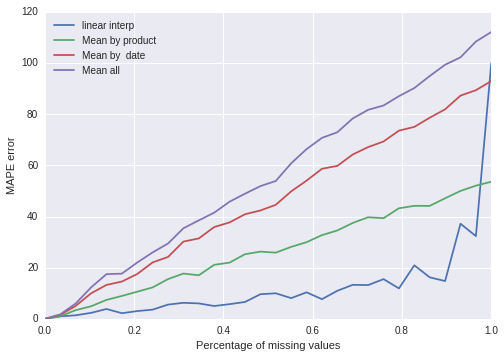

In [93]:
plt.plot(ratio_missing,np.mean(score_lin_interp,axis=0),label="linear interp")
plt.plot(ratio_missing,np.mean(score_product,axis=0),label="Mean by product")
plt.plot(ratio_missing,np.mean(score_date,axis=0),label="Mean by  date")
plt.plot(ratio_missing,np.mean(score_mean_train,axis=0),label="Mean all")
plt.legend(loc = 'best')
plt.xlabel('Percentage of missing values')
plt.ylabel('MAPE error')

### Partial conclusion
From that analysis we could clearly see that the linear regression was clearly the best strategy up to the moment when we have more than 95% of missing values (less than 2 true values). <br />
We then decided to see if by changing the order of linear interpolation we would do a better interpolation. <br />
We therefore repeated this operation to compare linear interpolations of order 1, 2 and 3

In [11]:
import random
from scipy.interpolate import interp1d
ratio_missing=trainDF.isnull().sum(axis=1).div(trainDF.shape[1])
trainDF2 = trainDF[ratio_missing==0]
k=30
idx = np.random.randint(0,trainDF2.shape[0],k)
ratio_missing = np.linspace(0,0.9,30)
score_order1 = np.zeros([k,ratio_missing.shape[0]])
score_order2 = np.zeros([k,ratio_missing.shape[0]])
score_order3 = np.zeros([k,ratio_missing.shape[0]])
for ir in range(ratio_missing.shape[0]):
    r = ratio_missing[ir]
    for i in range(k):
        same_product = trainDF[trainDF.product_id==trainDF2.iloc[idx[i],:]['product_id']] 
        same_date = trainDF[trainDF.date==trainDF2.iloc[idx[i],:]['date']] 
        x_true = trainDF2.iloc[idx[i],3:]
        x_missing = x_true.copy()
        x_missing[random.sample(xrange(0,x_true.shape[0]), np.int(x_true.shape[0]*r))]=np.nan 
        x=x_missing.values
        t = np.arange(x_true.shape[0])
        f = interp1d(t[~np.isnan(x)],x[~np.isnan(x)],"linear",bounds_error=False)
        y = f(t)
        x_interp = x_missing.copy()
        x_interp[:] = np.interp(t, t[~np.isnan(y)], y[[~np.isnan(y)]])
        score_order1[i,ir] = np.abs(x_true.sum() - x_interp.sum())/x_true.sum()*100
        f = interp1d(t[~np.isnan(x)],x[~np.isnan(x)],"quadratic",bounds_error=False)
        y = f(t)
        x_interp = x_missing.copy()
        x_interp[:] = np.interp(t, t[~np.isnan(y)], y[[~np.isnan(y)]])
        score_order2[i,ir] = np.abs(x_true.sum() - x_interp.sum())/x_true.sum()*100
        f = interp1d(t[~np.isnan(x)],x[~np.isnan(x)],"cubic",bounds_error=False)
        y = f(t)
        x_interp = x_missing.copy()
        x_interp[:] = np.interp(t, t[~np.isnan(y)], y[[~np.isnan(y)]])
        score_order3[i,ir] = np.abs(x_true.sum() - x_interp.sum())/x_true.sum()*100

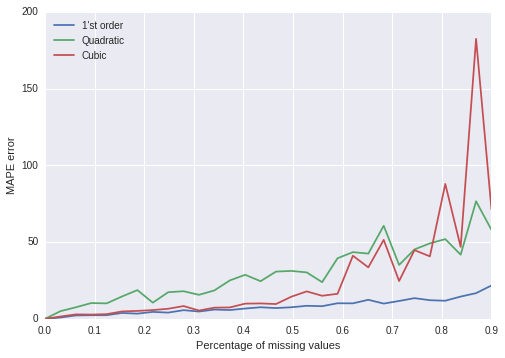

In [12]:
plt.plot(ratio_missing,np.mean(score_order1,axis=0),label="1'st order")
plt.plot(ratio_missing,np.mean(score_order2,axis=0),label="Quadratic")
plt.plot(ratio_missing,np.mean(score_order3,axis=0),label="Cubic")
plt.legend(loc = 'best')
plt.xlabel('Percentage of missing values')
plt.ylabel('MAPE error')

### Partial conclusion
It appears that an order of 1 is likely the best interpollation for our dataset (remin that we took only random observations) <br />
However, we still had a doubt about the extrapolation done for values at the begining: 09:30:00, 13:55:00,...  <br />
We then decided to chose between a linear extrapolation and a nearest extrapolation.

In [28]:
import random
from scipy.interpolate import interp1d
ratio_missing=trainDF.isnull().sum(axis=1).div(trainDF.shape[1])
trainDF2 = trainDF[ratio_missing==0]
k=30
idx = np.random.randint(0,trainDF2.shape[0],k)
ratio_missing = np.linspace(0,0.95,40)
score_linear = np.zeros([k,ratio_missing.shape[0]])
score_nearest = np.zeros([k,ratio_missing.shape[0]])
for ir in range(ratio_missing.shape[0]):
    r = ratio_missing[ir]
    for i in range(k):
        same_product = trainDF[trainDF.product_id==trainDF2.iloc[idx[i],:]['product_id']] 
        same_date = trainDF[trainDF.date==trainDF2.iloc[idx[i],:]['date']] 
        x_true = trainDF2.iloc[idx[i],3:]
        x_missing = x_true.copy()
        x_missing[random.sample(xrange(0,x_true.shape[0]), np.int(x_true.shape[0]*r))]=np.nan 
        x=x_missing.values
        t = np.arange(x_true.shape[0])
        f = interp1d(t[~np.isnan(x)],x[~np.isnan(x)],"linear",bounds_error=False)
        y = f(t)
        a=np.min(t[~np.isnan(y)])
        b=np.max(t[~np.isnan(y)])
        for inan in t[np.isnan(f(t))]:
            if inan<a:
                y[inan]=y[a]  
            if inan>b:
                y[inan]=y[b]
        x_interp = x_missing.copy()
        x_interp[:] = y
        if x_interp.isnull().sum()!=0:
            print "error"
            print i,r
        score_nearest[i,ir] = np.abs(x_true.sum() - x_interp.sum())/x_true.sum()*100
        f = interp1d(t[~np.isnan(x)],x[~np.isnan(x)],"quadratic",bounds_error=False)
        y = f(t)
        x_interp = x_missing.copy()
        x_interp[:] = np.interp(t, t[~np.isnan(y)], y[[~np.isnan(y)]])
        score_linear[i,ir] = np.abs(x_true.sum() - x_interp.sum())/x_true.sum()*100
        if x_interp.isnull().sum()!=0:
            print "error"
            print i,r

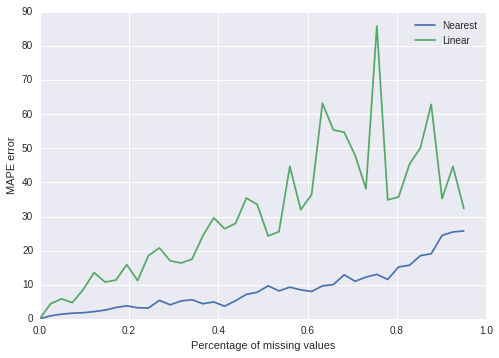

In [29]:
plt.plot(ratio_missing,np.mean(score_nearest,axis=0),label="Nearest")
plt.plot(ratio_missing,np.mean(score_linear,axis=0),label="Linear")
plt.legend(loc = 'best')
plt.xlabel('Percentage of missing values')
plt.ylabel('MAPE error')

### Conclusion
At the end of this analysis, we came up with an approach for filleng missinf values :
- pick lines with less than 3 volumes given and fill missing values with mean by product values
- For the other lines do
    - Perform linear interpolation of order 1 to fill "middle" missing values
    - Perform nearest extrapolation to fill "extremum" missing values

### Implementation

In [8]:
train_productDF = trainDF.groupby(by=["product_id"]).mean()
for i in range(trainDF.shape[0]):
    if trainDF.iloc[i,:].isnull().sum()>51:
        trainDF.iloc[i,3:] = train_productDF.ix[int(trainDF.loc[i,"product_id"]),3:]

trainTestDF = trainDF.append(testDF)
trainTest_productDF = trainTestDF.groupby(by=["product_id"]).mean()
for i in range(testDF.shape[0]):
    if testDF.iloc[i,:].isnull().sum()>51:
        testDF.iloc[i,3:] = trainTest_productDF.ix[int(testDF.loc[i,"product_id"]),3:]

from scipy.interpolate import interp1d
X = trainDF.ix[:,3:].values
t = np.arange(X.shape[1])
for i in range(trainDF.shape[0]):
    x = X[i,:]
    if np.sum(np.isnan(x)) != 0:
        f = interp1d(t[~np.isnan(x)],x[~np.isnan(x)],"linear",bounds_error=False)
        y = f(t)
        a=np.min(t[~np.isnan(y)])
        b=np.max(t[~np.isnan(y)])
        for inan in t[np.isnan(f(t))]:
            if inan<a:
                y[inan]=y[a]  
            if inan>b:
                y[inan]=y[b]
        X[i,:] = y
trainDF.ix[:,3:] = X

X = testDF.ix[:,3:].values
t = np.arange(X.shape[1])
for i in range(testDF.shape[0]):
    x = X[i,:]
    if np.sum(np.isnan(x)) != 0:
        f = interp1d(t[~np.isnan(x)],x[~np.isnan(x)],"linear",bounds_error=False)
        y = f(t)
        a=np.min(t[~np.isnan(y)])
        b=np.max(t[~np.isnan(y)])
        for inan in t[np.isnan(f(t))]:
            if inan<a:
                y[inan]=y[a]  
            if inan>b:
                y[inan]=y[b]
        X[i,:] = y
testDF.ix[:,3:] = X

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53]


# Feature engineering

## New Features

1) We also thought about computing some others features from the data:
    - Standard deviation of the volumes traded per day per product
    - Average of the volumes traded per day per product
    - Median of the volumes traded per day per product
    - Average of the volumes traded per day
    - Average of the volumes traded per product

2) We also thought it could help to **center and/or normalize** the time serie in each line but this made our prediction model less performant.

3) The last transformation we did was to compute the **logarithm** of the volumes traded in order to rescale those quantities, but again, it made the model less performant


In [31]:

trainDF["std_volume"] = trainDF.ix[:,3:].std(axis=1)
trainDF["mean_volume"] = trainDF.ix[:,3:-1].mean(axis=1)
trainDF["median_volume"] = trainDF.ix[:,3:-2].median(axis=1)
testDF["std_volume"] = trainDF.ix[:,3:].std(axis=1)
testDF["mean_volume"] = trainDF.ix[:,3:-1].mean(axis=1)
testDF["median_volume"] = trainDF.ix[:,3:-2].median(axis=1)

In [5]:
train_productDF = trainDF.groupby(by=["product_id"])["mean_volume"].mean()
trainDF["mean_product"] = np.nan
testDF["mean_product"] = np.nan
for i in train_productDF.index:
    trainDF.loc[trainDF["product_id"]==i,"mean_product"] = train_productDF[i]
    testDF.loc[testDF["product_id"]==i,"mean_product"] = train_productDF[i]

train_dateDF = trainDF.groupby(by=["date"])["mean_volume"].mean()
trainDF["mean_date"] = np.nan
testDF["mean_date"] = np.nan
for i in train_dateDF.index:
    trainDF.loc[trainDF["date"]==i,"mean_date"] = train_dateDF[i]
    testDF.loc[testDF["date"]==i,"mean_date"] = train_dateDF[i]
    
trainDF.head()

,ID,date,product_id,09:35:00,09:40:00,09:45:00,09:50:00,09:55:00,10:00:00,10:05:00,...,13:35:00,13:40:00,13:45:00,13:50:00,13:55:00,std_volume,mean_volume,median_volume,mean_product,mean_date
0,1,1,236,2457975.00,741777.14,973487.28,764018.92,1074769.92,3056492.88,1312440.80,...,959853.30,892596.88,528573.62,973928.60,972596.43,514829.480517,992148.350566,959853.30,669676.933156,1316245.31844
1,2,1,238,104198.40,61840.92,78523.02,128729.16,60789.84,18072.62,108036.10,...,51850.26,46478.41,17199.00,34500.62,37690.24,28488.172674,58143.496604,49990.20,137155.493317,1316245.31844
2,3,1,242,109497.00,152577.00,164024.00,204372.00,321545.70,346236.00,244627.00,...,105222.24,101646.00,79128.00,101248.00,367120.00,100591.055121,158554.703962,114064.45,556481.136149,1316245.31844
3,4,1,243,220467.28,161594.35,264893.44,300326.20,707391.68,327428.00,470549.60,...,565263.30,286416.00,71518.14,155752.10,123690.00,263452.858016,277328.958491,189836.01,195965.774032,1316245.31844
4,5,1,261,4470974.95,1448461.05,1500694.38,944346.50,958685.76,1685234.07,782275.54,...,795697.65,565374.30,832022.43,1425134.40,2310369.30,957376.612913,1061484.009057,759242.40,841314.195366,1316245.31844


## Time serie analysis

In this part we were motivated of finding a way of replacing, without losing information the time variables (volumes traded at 09:35, ..., 13:55) by new features that are less correlated and which will give better prediction. The features we wanted to compute, for each time serie, were :
    - The trend
    - The cycle
    - The auto regressive model coefficients
*N.B.: Thos features were not computed because too much time was needed to compute them on each of almost 7e5 time series in the dataset* 
### Trend
To compute the trend we did a simple polynomial fitting of the time serie

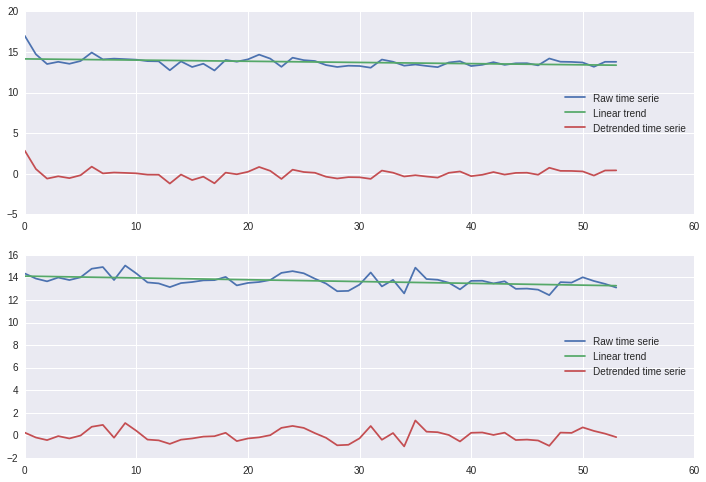

In [55]:
ts = np.log(trainDF.ix[0,3:])
x = ts.values
t = np.array(range(x.shape[0]))
model = np.polyfit(t, x, 1)
y = np.polyval(model, t)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
plt.plot(t,x,label="Raw time serie")
plt.plot(t,y,label="Linear trend")
plt.plot(t,x-y,label="Detrended time serie")
plt.legend(loc='best')
ax2 = fig.add_subplot(212)
ts = np.log(trainDF.ix[400,3:])
x = ts.values
t = np.array(range(x.shape[0]))
model = np.polyfit(t, x, 1)
y = np.polyval(model, t)
plt.plot(t,x,label="Raw time serie")
plt.plot(t,y,label="Linear trend")
plt.plot(t,x-y,label="Detrended time serie")
plt.legend(loc='best')
ts2_detrended = ts.copy()
ts2_detrended[:] = x-y

This Analysis confirms the information given in the challenge, there is an overall decreasing trend in the volumes traded in the day. <br />
I think those 2 new features are able to capture how quick the volume decrease and from which point they start decreasing.

### Auto regressive
In this part we start by checking whether the time series where stationary or not and we finally tried to model them with arma models.
- To check stationarity, we decided to compute the rollinf mean and rolling standard deviation and check taht they are constant in the time
- We also perform a Dickey-Fuller Test.

In [42]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

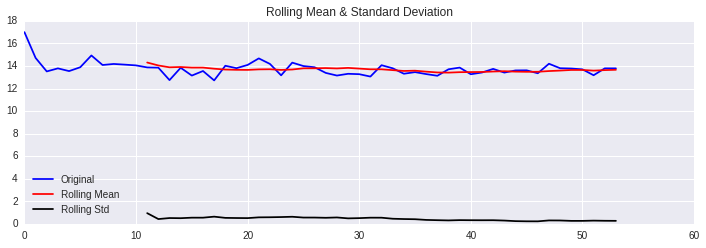

Results of Dickey-Fuller Test:
Test Statistic                -8.033363e+00
p-value                        1.931624e-12
#Lags Used                     0.000000e+00
Number of Observations Used    5.300000e+01
Critical Value (5%)           -2.917850e+00
Critical Value (1%)           -3.560242e+00
Critical Value (10%)          -2.596796e+00
dtype: float64


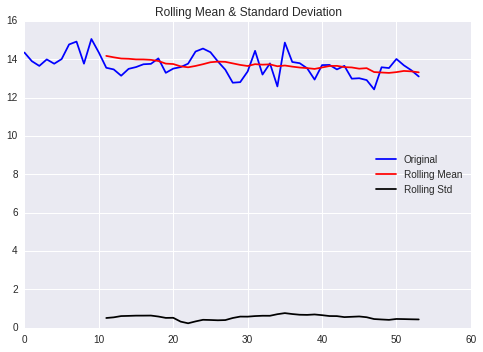

Results of Dickey-Fuller Test:
Test Statistic                 -3.437128
p-value                         0.009756
#Lags Used                      2.000000
Number of Observations Used    51.000000
Critical Value (5%)            -2.920142
Critical Value (1%)            -3.565624
Critical Value (10%)           -2.598015
dtype: float64


In [52]:
# ts[:] = (ts.values - np.mean(ts.values))/np.std(ts.values)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
test_stationarity(np.log(trainDF.ix[0,3:]))
ax2 = fig.add_subplot(212)
test_stationarity(np.log(trainDF.ix[400,3:]))

We those results we are very tempted to say the first time serie is stationary as the Test Statistic is very lower than the critical value so we can reject the null hypothesis (time serie is non stationary) with high probability.
<br /> However the is not true for the second time which has a slightly higher probability of beeing non stationary. This is because the decreasing trend is more important.

### Decomposing
We also cheched if those time serie decompose well into a trend and a seasonal part



In [75]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts = np.log(trainDF.ix[400,3:])
ts.index = pd.to_datetime(ts.index,format="%H:%M:%S")
# ts.index = pd.to_datetime(ts.index,unit=1)
# ts.index
decomposition = seasonal_decompose(ts)

trend = decomposition.trend

seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Choose ARMA order
We did that by computing the autocorellations and the partial autocorrelation of the signal (see http://people.duke.edu/~rnau/411arim3.htm)

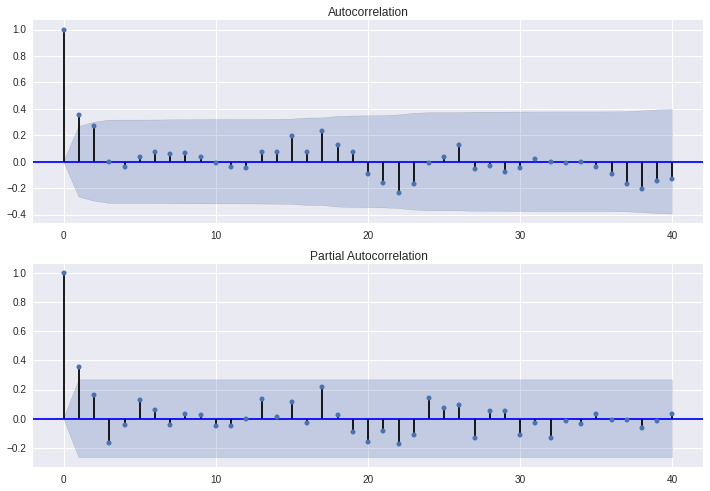

In [58]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)

In [88]:

arma_mod = sm.tsa.ARMA(ts.values,(2,2)).fit()
# arma_mod.select_order(5,ic='aic')
print arma_mod.params

print arma_mod.aic, arma_mod.bic, arma_mod.hqic
#

[ 13.69208003   0.20411343  -0.21288569   0.12047701   0.51678161]
93.4670407861 105.400945066 98.0694796688


## Manipulate the date
We also did a transformation of the variable date
- We computed the corresponding year,month,day,weekday,week,n_days
- We tranformed those raiables into one hot dummies varibles

In [ ]:
trainDF['date']=pd.to_datetime(trainDF['date'],unit='D')
testDF['date']=pd.to_datetime(testDF['date'],unit='D')
trainDF['year'] = trainDF['date'].dt.year
trainDF['month'] = trainDF['date'].dt.month
trainDF['day'] = trainDF['date'].dt.day
trainDF['weekday'] = trainDF['date'].dt.weekday
trainDF['week'] = trainDF['date'].dt.week
trainDF['n_days'] = trainDF['date'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)
        
trainDF = trainDF.join(pd.get_dummies(trainDF['year'], prefix='y'))
trainDF = trainDF.join(pd.get_dummies(trainDF['month'], prefix='m'))
trainDF = trainDF.join(pd.get_dummies(trainDF['day'], prefix='d'))
trainDF = trainDF.join(pd.get_dummies(trainDF['weekday'], prefix='wd'))
trainDF = trainDF.join(pd.get_dummies(trainDF['week'], prefix='w'))

testDF['year'] = testDF['date'].dt.year
testDF['month'] = testDF['date'].dt.month
testDF['day'] = testDF['date'].dt.day
testDF['weekday'] = testDF['date'].dt.weekday
testDF['week'] = testDF['date'].dt.week
testDF['n_days'] = testDF['date'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)
        
testDF = testDF.join(pd.get_dummies(testDF['year'], prefix='y'))
testDF = testDF.join(pd.get_dummies(testDF['month'], prefix='m'))
testDF = testDF.join(pd.get_dummies(testDF['day'], prefix='d'))
testDF = testDF.join(pd.get_dummies(testDF['weekday'], prefix='wd'))
testDF = testDF.join(pd.get_dummies(testDF['week'], prefix='w'))

trainDF=trainDF.drop(["year",'month','day','weekday','week'],axis=1)
testDF=testDF.drop(["year",'month','day','weekday','week'],axis=1)

# Model Selection and performance evaluation
In this part we compared results obtained by different regression model:

    - Linear regressor from the scikit learn package
    - Lasso from the scikit learn package
    - Random Forest from the scikit learn package
    - Gradient Boosting regressor from the scikit learn package
    - XGBOOST, which in another implementation of the gradient boosting regressor
The best performance were obtained with **XGBOOST** <br />
It is however important to say that we wanted to use as much as possible cross validation to give more statistical guarrantee on the results we obtained but, because of the high dimension of the dataset and the low ressources of our computers, we were not sometimes able to run all the iterations need for cross validation.<br />
Below we give a framework that could have been to do a good tuning of the XGBOOST

In [83]:
import xgboost as xgb
from sklearn.cross_validation import train_test_split
X_train = trainLablledDF.drop(['TARGET'], axis=1).values
y_train = trainLablledDF['TARGET'].values
X_test = testDF.values
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.3, random_state=0)

def evalerror(preds,xg_train):
    y_test = xg_train.get_label()
    return 'error',  np.mean(np.abs((preds-y_test ) / y_test)) * 100

scores = np.zeros([2,10,10]).shape
for i1,objective in enumerate(['reg:linear','reg:logistic']):
    for i2,eta in enumerate(np.linspace(0,1,10)):
        for i3,max_depth in enumerate(np.arange(5,X_train.shape[1],(X_train.shape[1]-5)/10)):
            param['objective'] = objective
            param['eta'] = eta
            param['max_depth'] = max_depth
            param['silent'] = 1
            param['nthread'] = 4
            
            watchlist = [ (xg_train,'train') ]
            num_round = 10
            bst = xgb.train(param, xg_train, num_round, watchlist ,feval=evalerror);
            y_pred = bst.predict( xg_test );
            
            scores[i1,i2,i3] = np.mean(np.abs((y_pred-y_test ) / y_test)) * 100
            

(2, 10, 10)

# Submition
The submition were then done after training the model on the best parameters

In [ ]:
y_pred = bst.predict( xg_test );
outFrame=pd.DataFrame(y_pred, columns=['TARGET'])
outFrame=pd.concat([idsFrame, outFrame], axis=1)
outFrame.to_csv('out.csv',index=False)